In [4]:
from pathlib import Path
import json
from more_itertools import with_iter
import pandas as pd
import numpy as np
from functools import partial
import cv2
import pytesseract
import matplotlib.pyplot as plt
import re
import difflib

In [5]:
with open('fighters.json','r') as fh:
    list_of_fighters = lof = list(map(str.upper, json.load(fh)))

In [6]:
annotations_path = Path('data/annotations')
afields = []

In [7]:
s1ar = []
for p in annotations_path.glob('*STATS-1.json'):
    with open(p) as po:
        pot = json.load(po)
        s1ar.append(pot)
s1ar = [[{k:v for k,v in s.items() if k in {'points','label'}} for s in a['shapes']] for a in s1ar]

In [8]:
s = []
for l in s1ar:
    for k in l:
        s.append(k)
s = pd.DataFrame(s)

In [9]:
x = (s[s['label']=='1 right name'])['points'].map(lambda l: cv2.boundingRect(np.array(l)))
x,y, dx, dy = list(map(int,np.mean(np.array(list(x.map(list)),dtype='int'), axis=0)))
x, y, dx, dy

(348, 330, 204, 74)

In [18]:
image_set = Path('images').glob('*-STATS-1.png')

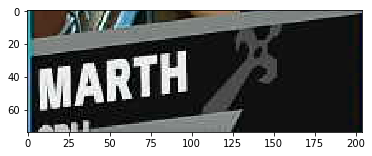

In [45]:
filename = str(image_set.__next__())
image = cv2.imread(filename)
roi = image[y:y+dy,x:x+dx]
plt.imshow(roi)

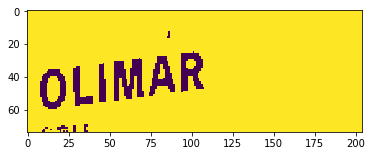

In [75]:
i = cv2.GaussianBlur(i,(3,3),0)
rv, i = cv2.threshold(roi, 180, 255, cv2.THRESH_BINARY_INV)
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(2,2))
erosion = cv2.dilate(i,kernel,iterations = 1)
plt.imshow(i)
plt.imshow(erosion)

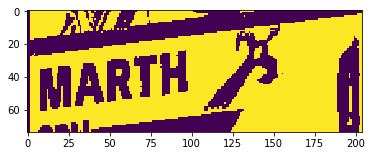

In [53]:
roi=cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
i = cv2.adaptiveThreshold(roi,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY_INV,55,0)
kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(2,2))
erosion = cv2.dilate(i,kernel,iterations = 1)
plt.imshow(i)

In [70]:
#config = ("-l eng --oem 1 --psm 7")
config = r'--psm 9 --user-patterns "/home/nate/Projects/clb4s/fightingwords.user-patterns" "bazaar"'
pytesseract.image_to_string(i, config=config)

'OLIMAR'

0 = Orientation and script detection (OSD) only.
1 = Automatic page segmentation with OSD.
2 = Automatic page segmentation, but no OSD, or OCR. (not implemented)
3 = Fully automatic page segmentation, but no OSD. (Default)
4 = Assume a single column of text of variable sizes.
5 = Assume a single uniform block of vertically aligned text.
6 = Assume a single uniform block of text.
7 = Treat the image as a single text line.
8 = Treat the image as a single word.
9 = Treat the image as a single word in a circle.
10 = Treat the image as a single character.
11 = Sparse text. Find as much text as possible in no particular order.
12 = Sparse text with OSD.
13 = Raw line. Treat the image as a single text line,
     bypassing hacks that are Tesseract-specifi
     
4 seems best for now...
Struct elem (2,3)

In [95]:
def process_image(roi):
    #roi = cv2.GaussianBlur(roi,(3,3),0)
    rv, i = cv2.threshold(roi, 180, 255, cv2.THRESH_BINARY_INV)
    #i = cv2.GaussianBlur(roi,(3,3),0)
    kernel = cv2.getStructuringElement(cv2.MORPH_CROSS,(2,3))
    erosion = cv2.dilate(i,kernel,iterations = 1)
    return erosion

def ocr_image(erosion):
    #config = (r'--psm 4',  r'--oem 1', r'--user-patterns "/home/nate/Projects/clb4s/fightingwords.user-patterns"', r'--lang "eng"', r'--tessdata-dir "/home/nate/Projects/clb4s/tessdata/"', r'"bazaar"')
    #config = r'blah blah bl;ah --psm 5 --oem 1 --tessdata-dir "/usr/share/tesseract-ocr/4.00/tessdata" -c user-patterns="/home/nate/Projects/clb4s/fightingworrrds.user-patterns" "bazaar"'
    config = r'--psm 4 --oem 1 --user-patterns "/home/nate/Projects/clb4s/fightingwords.user-patterns"'
    tff = pytesseract.image_to_string(erosion, config=config)
    return tff

def extract_roi(image,x,y,dx,dy, m=(10,10)):
    # m is (y,x)
    roi = image[y+m[0]:y+dy-m[0],x+m[1]:x+dx-m[1]]
    return roi
    

In [96]:
atf = set()
bail_after = 69
k = 0
for ip in image_set:
    if k > bail_after:
        break
    k += 1
    image = cv2.imread(str(ip))

    roi = extract_roi(image,x,y,dx,dy,(10,10))
    roi = process_image(roi)
    tff = ocr_image(roi)

    atf.add(tff)

In [61]:
def printable(s):
    ts = re.sub(r'[^\w\s]','',s, re.UNICODE)
    return re.sub(r'_','',ts).strip()

In [97]:
# NORMAL
atf = list(map(lambda s: s.replace('\n',' ').upper(), atf))
atf = list(map(printable, atf))
list(map(lambda s: (s,difflib.get_close_matches(s, lof, n=1, cutoff=0.6)), atf))

[('', []),
 ('OUNG LINK', ['YOUNG LINK']),
 ('AT AE CORRIN', ['CORRIN']),
 ('INKLING', ['INKLING']),
 ('CHROM', ['CHROM']),
 ('BOWSER', ['BOWSER']),
 ('WARIO', ['WARIO']),
 ('FON LINK', ['TOON LINK']),
 ('SNAKE', ['SNAKE']),
 ('FOX', ['FOX']),
 ('LINK', ['LINK']),
 ('EE YUCK HUNT', ['DUCK HUNT']),
 ('OKEMON A INER', ['POKEMON TRAINER']),
 ('SIDDY KONG', ['DIDDY KONG']),
 ('JLLAGER', ['VILLAGER']),
 ('MEWTWO', ['MEWTWO']),
 ('RYU', ['RYU']),
 ('UCARIO', ['LUCARIO']),
 ('EACH', ['PEACH']),
 ('CLOUD', ['CLOUD']),
 ('IRANHA  ANT', ['PIRANHA PLANT']),
 ('WOLF', ['WOLF']),
 ('LUCAS', ['LUCAS']),
 ('YARK SAMUS', ['DARK SAMUS']),
 ('MEGA MAN', ['MEGA MAN']),
 ('LUIGI', ['LUIGI']),
 ('SONIC', ['SONIC']),
 ('SIMON', ['SIMON']),
 ('SS YOSHI', ['YOSHI']),
 ('MARIO', ['MARIO']),
 ('EEE IGGLYPUFF', ['JIGGLYPUFF']),
 ('ROBIN', ['ROBIN']),
 ('ILLAGER', ['VILLAGER']),
 ('SAMUS', ['SAMUS']),
 ('PACMAN', ['PAC-MAN']),
 ('YP GAME WATCH', ['MR. GAME & WATCH']),
 ('NE NEAT CE CLIMBERS', ['ICE CLIMBERS']),
 

In [92]:
# BLURRY
atf = list(map(lambda s: s.replace('\n',' ').upper(), atf))
atf = list(map(printable, atf))
list(map(lambda s: (s,difflib.get_close_matches(s, lof, n=1, cutoff=0.6)), atf))

[('', []),
 ('OUNG LINK', ['YOUNG LINK']),
 ('LUCAS', ['LUCAS']),
 ('AN SHULK', ['SHULK']),
 ('ALPH', []),
 ('INKLING', ['INKLING']),
 ('CHROM', ['CHROM']),
 ('AT AE DALUTENA', ['PALUTENA']),
 ('BOWSER', ['BOWSER']),
 ('ER SUIT MUS', ['ZERO SUIT SAMUS']),
 ('IKE', ['IKE']),
 ('WARIO', ['WARIO']),
 ('SNAKE', ['SNAKE']),
 ('ROB', ['ROB']),
 ('FOX', ['FOX']),
 ('OO DR MARIO', ['DR. MARIO']),
 ('ITTLE MAC', ['LITTLE MAC']),
 ('GRENINJA', ['GRENINJA']),
 ('ITTLEMAC', ['LITTLE MAC']),
 ('OKEMON A INER', ['POKEMON TRAINER']),
 ('RYU', ['RYU']),
 ('SIDDY KONG', ['DIDDY KONG']),
 ('PICHU', ['PICHU']),
 ('I DAISY', ['DAISY']),
 ('UCARIO', ['LUCARIO']),
 ('EE I RANHA  ANT', ['PIRANHA PLANT']),
 ('PEACH', ['PEACH']),
 ('CE CLIMBERS', ['ICE CLIMBERS']),
 ('FALCO', ['FALCO']),
 ('WOLF', ['WOLF']),
 ('CORRIN', ['CORRIN']),
 ('MEGA MAN', ['MEGA MAN']),
 ('NG DEDEDE', ['KING DEDEDE']),
 ('SONIC', ['SONIC']),
 ('SIMON', ['SIMON']),
 ('ILLAGER', ['VILLAGER']),
 ('MARIO', ['MARIO']),
 ('SAMUS', ['SAMUS'])

In [80]:
atf

['',
 '2 SHULK',
 'CHROM',
 'BOWSER',
 'YGGLIPUFF',
 'MEWTWO',
 'LUCINA',
 'WA DAME 4 WALL',
 'SABELLE',
 'PIKACHU',
 'WARIO',
 'T CORRIN',
 'FF  GANONDORF',
 'SNAKE',
 'PACMAN',
 'SHEIK',
 'FOX',
 'GRENINJA',
 'ALCO',
 'LINK',
 'KING DEDEDE',
 'PICHU',
 'CAP SAIN PACTON',
 'WOLF',
 'FALCO',
 'POR MN TRAINER',
 'META KNIGHT',
 'LUCAS',
 'F GANONDORF',
 'SONIC',
 'SIMON',
 'FY A  LUCAS',
 'ROD',
 'TOON LINK',
 'AA PIKACHU',
 'WOLF',
 'RICHTER',
 'A ZELDA',
 'AS CORRIN',
 'A MARTH',
 'MARIO',
 'AE DUCK HUNT',
 'MARTH',
 'SOI VILLAGER',
 'EE INKLING',
 'LUCARIO',
 'AM  PIRANHA 1ANT',
 'PIT',
 'Z SHULK',
 'YOSHI',
 'BAYONETTA',
 'KIRBY',
 'RIDLEY',
 'BI  ROBIN',
 'YGGLYPUFF',
 'DARK PIT']

In [67]:
atf

['',
 'PET A OLIMAR',
 'RON PF',
 'NGAUPUREC',
 'TO GLPUFE  JIGGLYPUFF F',
 'OLIMAR',
 'AVONETTA',
 'PEACH',
 'BOWSER F BOWSER',
 'A AY',
 'R08 QF',
 'ME IEEE  YOUN UN UNAS F',
 'SNAKE WF',
 'PACMAN',
 'PICHU AS',
 'RAE  A',
 'TOON LINK OA',
 'R08 MQ',
 'KIRBY AY',
 'MARTH',
 'SAMS 7',
 'KE',
 'MEMC',
 'ISABELLE MY',
 'EE DARK A VE EEE',
 'CLOUD KK',
 'LINK A',
 'WARIOWY',
 'ROBIN',
 'MAE OK',
 'EE MEWTWOR',
 'SNAKE FF',
 'CON',
 'RT    ICECUMBERS',
 'KI WICK OK F',
 '2 TA X EE   FOX   TI EE',
 'PICHU AS F',
 'PAIS 62',
 'KEN OF',
 'WETAINGHT A',
 'ES  LITLENAC',
 'EY VILLAGER WY',
 'PEACH 6',
 'TUCARIO',
 'AE MR I  EN SF',
 'FO PO EATEN   TI PALUTENAS  CE A  4',
 '2 OE WARIOW',
 'PICHU AS',
 'TUCIWA A',
 'A  OLIMAR',
 'SE DARK SAMUS 4 I',
 'EE WARIO']